<a href="https://colab.research.google.com/github/nikita-0209/ml_quark_gluon/blob/main/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost

Reference: https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390
1. Details of Hyperparameters
2. Processing Data before Feeding into Network
3. How XGBoost Works (broad level)

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
labels = np.load("/content/drive/MyDrive/lhc/nopid_rTrue_pFalse_tTrue_tw1.0_cf_False_maskTrue_cmaskFalse_nc_100_MD_1000_DF_1000_NH_4_NL_4_NHL_2_temp_0.10_opt_adam_bsize_128_lr_0.00005_SB_1.0_N_1jetclr_labs_1.npy")

In [ ]:
reps = np.load("/content/drive/MyDrive/lhc/nopid_rTrue_pFalse_tTrue_tw1.0_cf_False_maskTrue_cmaskFalse_nc_100_MD_1000_DF_1000_NH_4_NL_4_NHL_2_temp_0.10_opt_adam_bsize_128_lr_0.00005_SB_1.0_N_1jetclr_reps_1.npy")[:, 0]

In [ ]:
labels_train, labels_test, reps_train, reps_test = train_test_split(labels, reps, test_size=0.33, random_state=69)

In [ ]:
model = xgb.XGBClassifier()
model.fit(reps_train, labels_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Predict
y_pred = model.predict(reps_test)

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Normalized confusion matrix
[[0.81553398 0.18446602]
 [0.27960048 0.72039952]]


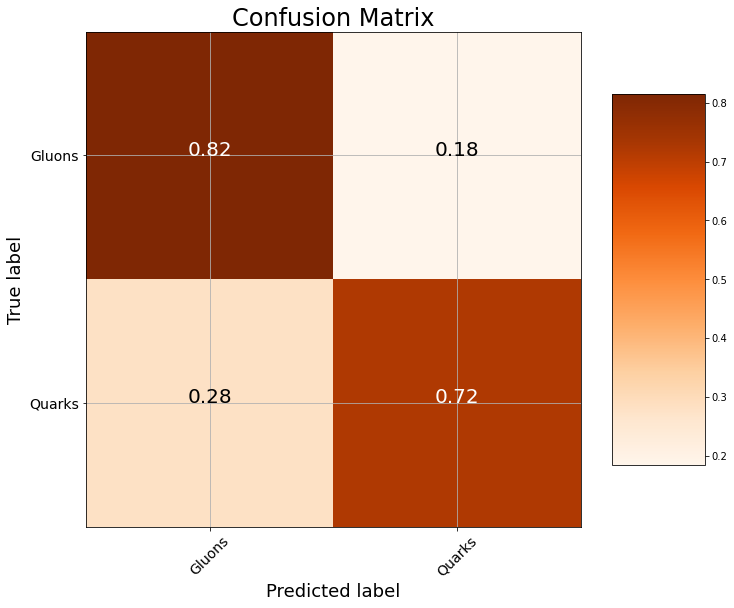

In [ ]:
cm = confusion_matrix(labels_test, y_pred)
# 0 for gluons and 1 for quarks
plot_confusion_matrix(cm, classes = ['Gluons', 'Quarks'],
                      title = 'Confusion Matrix')

In [ ]:
accuracy_score(labels_test, y_pred)

0.7679090909090909

In [ ]:
# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(reps_train)
train_rf_probs = model.predict_proba(reps_train)[:, 1]

In [ ]:
# Testing predictions (to determine performance)
y_pred = model.predict(reps_test)
rf_probs = model.predict_proba(reps_test)[:, 1]

Recall Baseline: 1.0 Test: 0.72 Train: 0.73
Precision Baseline: 0.5 Test: 0.8 Train: 0.8
Roc Baseline: 0.5 Test: 0.84 Train: 0.85


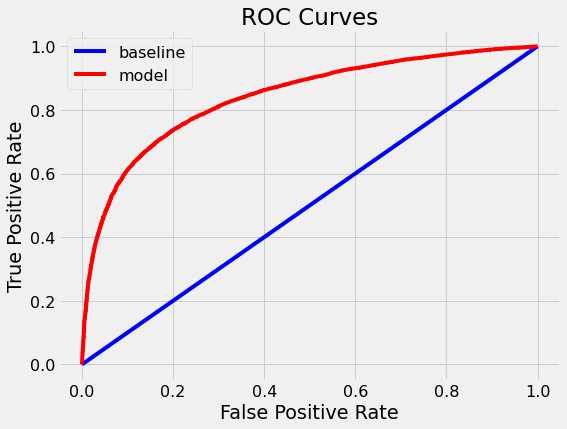

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(labels_test, 
                                     [1 for _ in range(len(labels_test))])
    baseline['precision'] = precision_score(labels_test, 
                                      [1 for _ in range(len(labels_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(labels_test, predictions)
    results['precision'] = precision_score(labels_test, predictions)
    results['roc'] = roc_auc_score(labels_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(labels_train, train_predictions)
    train_results['precision'] = precision_score(labels_train, train_predictions)
    train_results['roc'] = roc_auc_score(labels_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(labels_test, [1 for _ in range(len(labels_test))])
    model_fpr, model_tpr, _ = roc_curve(labels_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

evaluate_model(y_pred, rf_probs, train_rf_predictions, train_rf_probs)

### Hyperparameter Tuning

In [ ]:

param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [ ]:
from sklearn.model_selection import GridSearchCV

# Init classifier
model = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(model, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
_ = grid_cv.fit(reps_train, labels_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
grid_cv.best_score_

In [ ]:
grid_cv.best_params_